In [1]:
# Add this at the beginning of the notebook, before any other imports
import sys
import os

sys.path.append(os.path.dirname(os.path.abspath('.')))

In [2]:
from langchain_core.messages import HumanMessage, BaseMessage, AIMessage

from typing import Annotated, Any, Dict, Sequence, TypedDict

import json
import pandas as pd
import numpy as np

import yfinance as yf
import pandas as pd
import numpy as np
from typing import Dict, List, Tuple, Optional


from langgraph.graph import StateGraph, END

from typing import (
    Annotated,
    Sequence,
    TypedDict,
)
from langchain_core.messages import BaseMessage
from langgraph.graph.message import add_messages

import json
from langchain_core.messages import ToolMessage, SystemMessage
from langchain_core.runnables import RunnableConfig

from agents.utils import NewsAnalystState
from tools.yfinance_news import yf_tool
from tools.ddg_search import ddg_search
from agents.news_analyst_prompts import NEWS_ANALYST_AGENT_SYSTEM_PROMPT

from langchain_openai import ChatOpenAI
from langchain_core.tools import tool

USER_AGENT environment variable not set, consider setting it to identify your requests.


In [3]:
@tool
def news_retriever(query: Annotated[str, "keywords or search query used for searching news"]) -> int:
    """Tool that retrieves news, articles, and research reports"""
    return query


tools = [news_retriever]
tools_by_name = {tool.name: tool for tool in tools}

model = ChatOpenAI(model="gpt-4o-mini")
model = model.bind_tools(tools)

In [4]:
# res = model.invoke("trump meme coin")

In [5]:
# res

AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'call_9x84c79liamy5oY3OtkazU6p', 'function': {'arguments': '{"query":"Trump meme coin"}', 'name': 'news_retriever'}, 'type': 'function'}], 'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 19, 'prompt_tokens': 64, 'total_tokens': 83, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-4o-mini-2024-07-18', 'system_fingerprint': 'fp_72ed7ab54c', 'finish_reason': 'tool_calls', 'logprobs': None}, id='run-6289dda9-8f6b-4e42-9ca1-4ade8071ba8c-0', tool_calls=[{'name': 'news_retriever', 'args': {'query': 'Trump meme coin'}, 'id': 'call_9x84c79liamy5oY3OtkazU6p', 'type': 'tool_call'}], usage_metadata={'input_tokens': 64, 'output_tokens': 19, 'total_tokens': 83, 'input_token_details': {'audio': 0, 'cache_read': 0}, 'output_token_details': {

In [6]:
# query = res.tool_calls[0]["args"]

In [44]:
# res.tool_calls[0]

{'name': 'news_retriever',
 'args': {'query': 'Trump meme coin'},
 'id': 'call_9x84c79liamy5oY3OtkazU6p',
 'type': 'tool_call'}

In [8]:
query

{'query': 'Trump meme coin'}

In [8]:
res_yf = yf_tool.invoke(query)

In [9]:
res_yf

[{'title': "Bitcoin's coming boom, Trump's stock and meme coin sink, and Netflix hits $1,000: Markets news roundup",
  'description': 'Christopher McMahon, CEO of Aquinas Wealth Advisors and author of “Faithful Finances”, spoke with Quartz for the latest installment of our “Smart Investing” video series.',
  'content': '\n\n\n\n\nBitcoin\'s coming boom, Trump\'s stock and meme coin sink, and Netflix hits $1,000: Markets news roundup\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n \n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n  \n\n\n\n              News  Today\'s news   US   Politics   World   Tech  Reviews and deals  Audio  Computing  Gaming  Health  Home  Phones  Science  TVs     Climate change   Health   Science   Originals  The 360     Newsletters    Life  Health  COVID-19  Fall allergies  Health news  Mental health  Relax  Sexual health  Studies  

In [5]:
def node_call_yfinance_news(state: NewsAnalystState):
    tool_call = state["messages"][-1].tool_calls
    query = tool_call[0]["args"]

    response = yf_tool.invoke(query)
    print(f"alex-debug fyinance news response: {response}")
    content = json.dumps([
        {
            "title": item["title"],
            "description": item["description"]
        } for item in response
    ])
    # message = ToolMessage(
    #     content=content,
    #     name="yfinance_news",
    #     tool_call_id="",
    # )
    message = HumanMessage(content=content, name="yfinance_news")
    print(f"alex-debug fyinance news message: {message}")
    return {
        "messages": [message],
        "metadata": {
            "yfinance_news": response
        }
    }


def node_call_ddg_search(state: NewsAnalystState):
    tool_call = state["messages"][-1].tool_calls[0]
    query = tool_call["args"]
    
    response = ddg_search.invoke(query)
    print(f"alex-debug ddg search response: {response}")
    content = json.dumps([
        {
            "title": item["title"],
            "description": item["description"]
        } for item in response
    ])
    # message = ToolMessage(
    #     content=content,
    #     name="ddg_search",
    #     tool_call_id="",
    # )
    message = HumanMessage(content=content, name="ddg_search")
    print(f"alex-debug ddg search message: {message}")
    return {
        "messages": [message],
        "metadata": {
            "ddg_search": response
        }
    }

In [6]:
# Define the node that calls the model
def call_model(
    state: NewsAnalystState,
    config: RunnableConfig,
):
    system_prompt = SystemMessage(NEWS_ANALYST_AGENT_SYSTEM_PROMPT)
    response = model.invoke([system_prompt] + state["messages"], config)
    return {"messages": [response]}


def should_continue(state: NewsAnalystState):
    messages = state["messages"]
    last_message = messages[-1]
    if not last_message.tool_calls:
        return ["end"]
    else:
        return ["yfinance_news", "ddg_search"]


def news_analyst_agent():
    workflow = StateGraph(NewsAnalystState)

    workflow.add_node("agent", call_model)
    workflow.add_node("yfinance_news", node_call_yfinance_news)
    workflow.add_node("ddg_search", node_call_ddg_search)

    workflow.set_entry_point("agent")
    workflow.add_conditional_edges(
        "agent",
        should_continue,
        ["yfinance_news", "ddg_search", END]
    )
    workflow.add_edge("yfinance_news", "agent")
    workflow.add_edge("ddg_search", "agent")

    graph = workflow.compile()

    return graph


In [7]:
news_graph = news_analyst_agent()

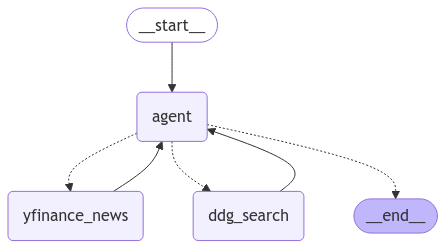

In [8]:
from IPython.display import Image, display

display(Image(news_graph.get_graph().draw_mermaid_png()))

In [9]:
from uuid import uuid4

thread_id = str(uuid4())
thread_id

'cc5a8d43-8217-49b4-8f6a-460b09611588'

In [10]:
res = news_graph.invoke(
    input={
        "messages": [HumanMessage(content="trump meme coin")],
        "metadata": {}
    },
    config={
        "configurable": {
            "thread_id": thread_id
        }
    }
)

alex-debug ddg search response: [{'title': 'President Trump meme coin raises concerns, Massachusetts Republican John Deaton says', 'description': 'John Deaton, who ran against Elizabeth Warren in the Massachusetts Senate race, talks about the state of politics on the national and local level,', 'content': None, 'link': 'https://www.msn.com/en-us/politics/government/president-trump-meme-coin-raises-concerns-massachusetts-republican-john-deaton-says/ar-AA1xTMAI'}, {'title': "Why Trump's Meme Coins Have Alarmed Both Crypto Insiders and Legal Experts", 'description': "Trump's crypto tokens are raising ethical and geopolitical concerns--and are worrying even Trump's staunchest pro-crypto supporters", 'content': None, 'link': 'https://www.msn.com/en-us/news/us/why-trump-s-meme-coins-have-alarmed-both-crypto-insiders-and-legal-experts/ar-AA1xG9jF'}, {'title': 'Trump meme coins get mixed response from the crypto industry', 'description': 'President Donald Trump and First Lady Melania Trump bot

BadRequestError: Error code: 400 - {'error': {'message': "An assistant message with 'tool_calls' must be followed by tool messages responding to each 'tool_call_id'. The following tool_call_ids did not have response messages: call_9T6o7yQsO4I5tz8gO8KS2KgK", 'type': 'invalid_request_error', 'param': 'messages.[3].role', 'code': None}}